# Shapelets

## Matrix Profiles for Machine Learning - Using STUMPY

[STUMPY](https://github.com/TDAmeritrade/stumpy) is a powerful and scalable python library for modern time series analysis and at it's core, efficiently computes something called a matrix profile.

### What is a Shapelet?

Informally, time series "shapelets" are time seris subsequences which are, in some sense maximally representative of a class. For example, imagine a time series that tracked the electricity consumption being used by a large appliances within your home for five years. Each time you run your clothes dryer, dishwasher or air conditioner, your power meter will record the electricity being consumed and just by looking at the time series, you'll likely be able to associate an electricity consumption "signature" (shape, duration, maximum energy usage, etc) for each appliance. 

Recent research suggest that matrix profiles can be used to efficiently identify shapelets of a particular class.

In [1]:
%matplotlib inline

import stumpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import metrics

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

**Loading the GunPoint Dataset**

This dataset is a motion capture time series that tracks the movement of an actor's right hand and contains two classes: 1.Gun, 2. Point.

In the *Gun* class, the actors draw a physical gun from a hip-mounted holster, point the gun at a target for approximately one second, then return the gun to the holster, and relax their hand to their sides. In the *Point* class, the actors leave their gun by their sides and, instead, they point their index fingers toward the target. For both classes, the centroid of the actor's right hand was tracked to represent its motion. 

In [7]:
train_df = pd.read_csv('https://zenodo.org/record/4281349/files/gun_point_train_data.csv?download=1')

gun_df = train_df[train_df['0']==0].iloc[:,1:].reset_index(drop=True)

gun_df = (gun_df.assign(NaN=np.nan)
                .stack(dropna=False)
                .to_frame()
                .reset_index(drop=True)
                .rename({0:"Centroid Location"}, axis='columns'))


point_df = train_df[train_df['0']==1].iloc[:,1:].reset_index(drop=True)

point_df = (point_df.assign(NaN=np.nan)
                .stack(dropna=False)
                .to_frame()
                .reset_index(drop=True)
                .rename({0:"Centroid Location"}, axis='columns'))

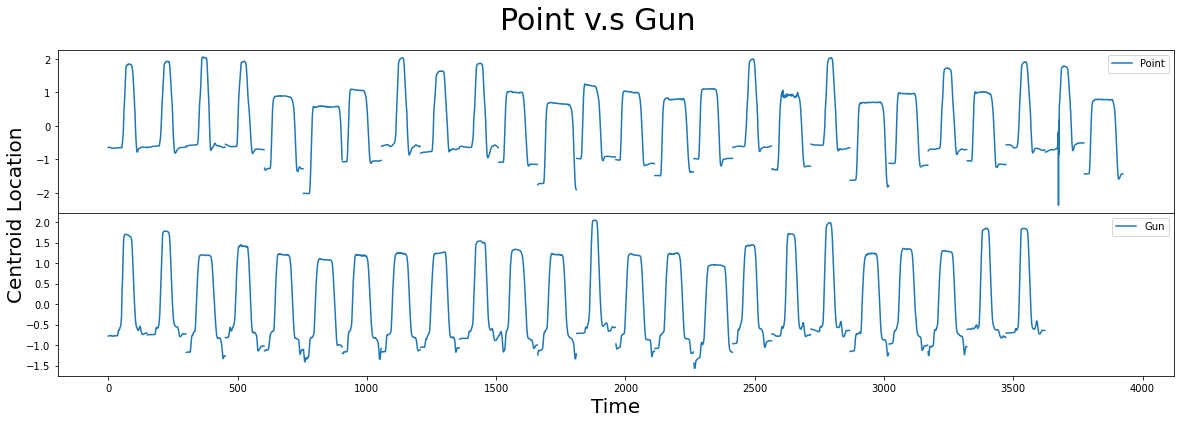

In [9]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0})
plt.suptitle('Point v.s Gun',fontsize='30')
plt.xlabel('Time',fontsize='20')
fig.text(.09,.5,'Centroid Location',va='center',rotation='vertical',fontsize='20')

axs[0].plot(point_df,label='Point')
axs[0].legend()
axs[1].plot(gun_df,label='Gun')
axs[1].legend()
plt.show()

### Finding candidates Shapelets with Matrix Profiles

A matrix profile PAA, calculated from a single time series TA, is called a "self join" and allow you to identify conserved subsequences within TA. However a matrix profile PAB computed acrros two different time series, TA and TB, is more commonly referred to as an "AB-join". Essentially, an AB join compares all of the subsequences in TA with all subsequences in TB in order to determine if there are any subsequences in TA that can also be found in TB. In contrast, if we swap the time series and compute PBA then this annotates every subsequence in TB with it's nearest neighbor subsequence in TA. 

We can utilize matrix profiles to heuristically "suggest" candidate shapelets and the main intuition is that if a discriminative patterns is present in Gun class but not in the Point class, then we would expect to see one or more "bumps" in their corresponding P(Point,Point)-P(Point,Gun) or (P(Gun,Gun)-P(Gun,Point)).

For simplicity we will calculate de matrix profiles using a subsequence lenght of 38 (as suggested in original paper). *It might be useful to try other subsequences lenghts to find other level of patterns.*

In [10]:
m = 38

P_Point_Point = stumpy.stump(point_df['Centroid Location'], m)[:,0].astype(float)

P_Point_Gun = stumpy.stump(
                    point_df['Centroid Location'], 
                    m,
                    gun_df['Centroid Location'],
                    ignore_trivial=False)[:,0].astype(float)

In [11]:
P_Point_Point[P_Point_Point == np.inf] = np.nan
P_Point_Gun[P_Point_Gun == np.inf] = np.nan

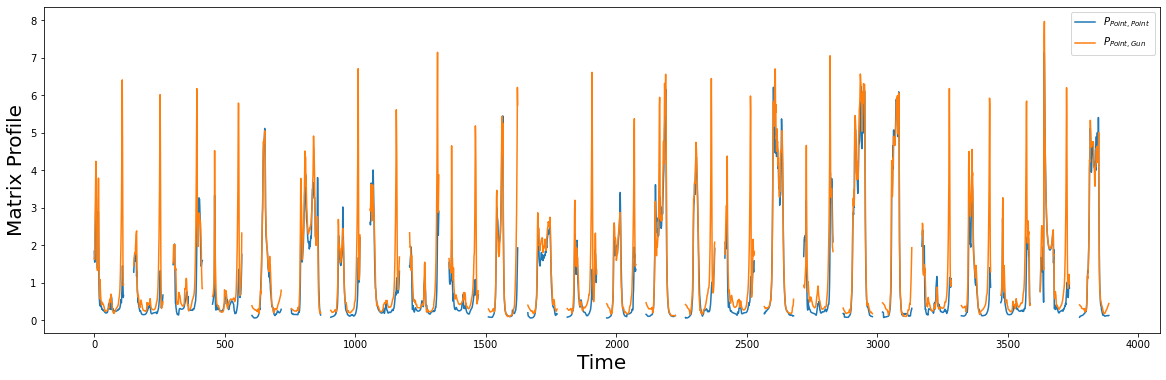

In [12]:
plt.plot(P_Point_Point, label="$P_{Point,Point}$")
plt.plot(P_Point_Gun, color="C1", label="$P_{Point,Gun}$")
plt.xlabel("Time", fontsize="20")
plt.ylabel("Matrix Profile", fontsize="20")
plt.legend()
plt.show()

Next we can highlight the major deviation between the two matrix profiles by plotting the difference between P(Point,Point) and P(Point,Gun).

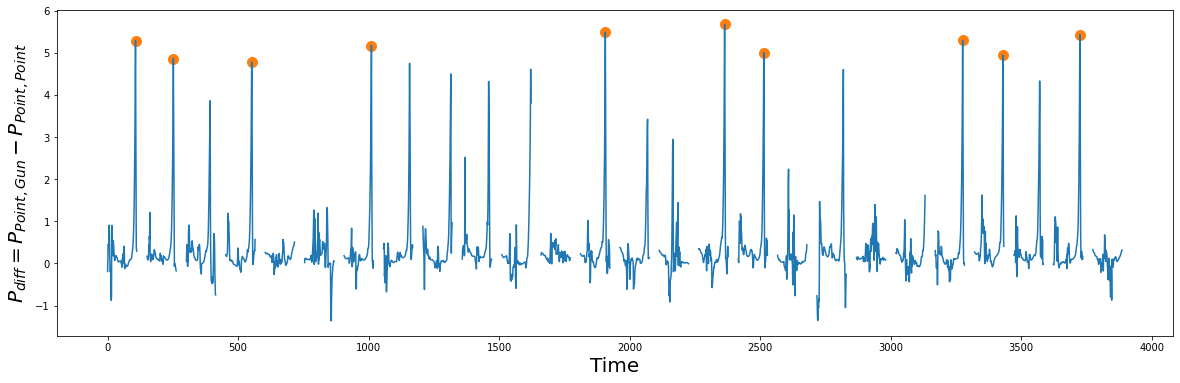

In [13]:
P_diff = P_Point_Gun - P_Point_Point
idx = np.argpartition(np.nan_to_num(P_diff),-10)[-10:]

plt.suptitle('',fontsize='30')
plt.xlabel('Time',fontsize='20')
plt.ylabel("$P_{diff} = P_{Point,Gun} - P_{Point, Point}$", fontsize="20")
plt.plot(idx, P_diff[idx], color="C1", marker="o", linewidth=0, markersize=10)
plt.plot(P_diff)
plt.show()

Lets extract discovers shapelets and plot them:

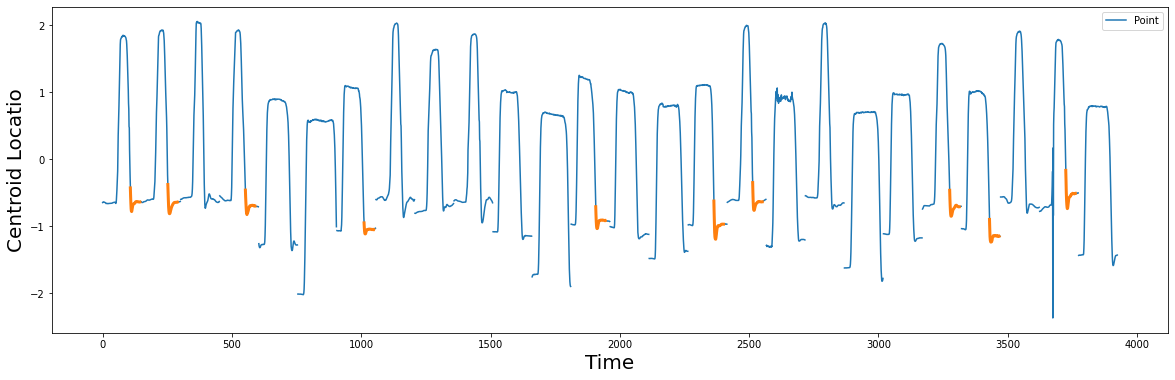

In [14]:
point_shapelets = []
for i in idx:
    shapelet = point_df.iloc[i:i+m,0]
    point_shapelets.append(shapelet)

plt.xlabel('Time',fontsize='20')
plt.ylabel('Centroid Locatio',fontsize='20')
plt.plot(point_df,label='Point')

for i, shapelet in zip(idx, point_shapelets):
    plt.plot(range(i,i+m),shapelet,color='C1',linewidth=3.0)

plt.legend()
plt.show()

### Building a simple classifier

Now lets build 10 separate decision tree models based on these shapelets and see how well they can help us distinguish between the Point class and the Gun class. 

In [15]:
test_df = df = pd.read_csv("https://zenodo.org/record/4281349/files/gun_point_test_data.csv?download=1")
# Get the train and test targets
y_train = train_df.iloc[:, 0]
y_test = test_df.iloc[:, 0]

Now, for our classification task, each shapelets need to be evaluated in terms of its predictive power. Thus, we first calculate the distance (pairwise euclidean distance) between a shapelet and every subsequence within each time series or sample. Then, the smallest value is kept to understand if a close match of shapelet in the time series has been found. The **stumpy.mass** function is perfectly suited for this task:

In [16]:
def distance_to_shapelet(data, shapelet):
    '''
    Compute the minimun distance between each data sample and a shapelet of interest
    '''
    data = np.asarray(data)
    X = np.empty(len(data))
    for i in range(len(data)):
        D = stumpy.mass(shapelet,data[i])
        X[i] = D.min()
    return X.reshape(-1,1)

clf = tree.DecisionTreeClassifier()
for i, shapelet in enumerate(point_shapelets):
    X_train = distance_to_shapelet(train_df.iloc[:,1:],shapelet)
    X_test = distance_to_shapelet(test_df.iloc[:,1:],shapelet)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test.reshape(-1,1))
    print(f'Accuracy for shapelet {1} = {round(metrics.accuracy_score(y_test, y_pred),3)}')

Accuracy for shapelet 1 = 0.867
Accuracy for shapelet 1 = 0.833
Accuracy for shapelet 1 = 0.807
Accuracy for shapelet 1 = 0.833
Accuracy for shapelet 1 = 0.933
Accuracy for shapelet 1 = 0.873
Accuracy for shapelet 1 = 0.873
Accuracy for shapelet 1 = 0.833
Accuracy for shapelet 1 = 0.86
Accuracy for shapelet 1 = 0.913


### Shapelets for Gun class

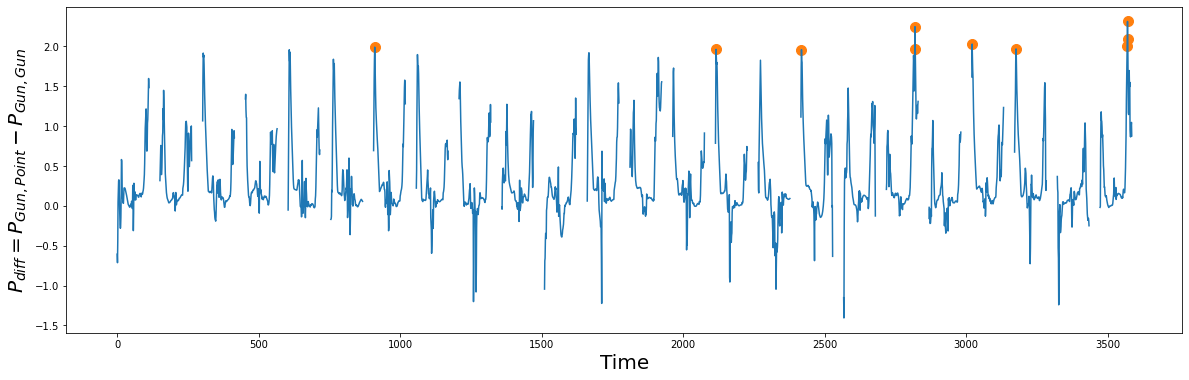

In [20]:
m = 38
P_Gun_Gun = stumpy.stump(gun_df["Centroid Location"], m)[:, 0].astype(float)
P_Gun_Point = stumpy.stump(gun_df["Centroid Location"], m, point_df["Centroid Location"], ignore_trivial=False)[:, 0].astype(float)
P_Gun_Gun[P_Gun_Gun == np.inf] = np.nan
P_Gun_Point[P_Gun_Point == np.inf] = np.nan
P_diff = P_Gun_Point - P_Gun_Gun
idx = np.argpartition(np.nan_to_num(P_diff), -10)[-10:]  # get the top 10 peak locations in P_diff
plt.suptitle("", fontsize="30")
plt.xlabel("Time", fontsize="20")
plt.ylabel("$P_{diff} = P_{Gun, Point} - P_{Gun, Gun}$", fontsize="20")
plt.plot(idx, P_diff[idx], color="C1", marker="o", linewidth=0, markersize=10)
plt.plot(P_diff)
plt.show()

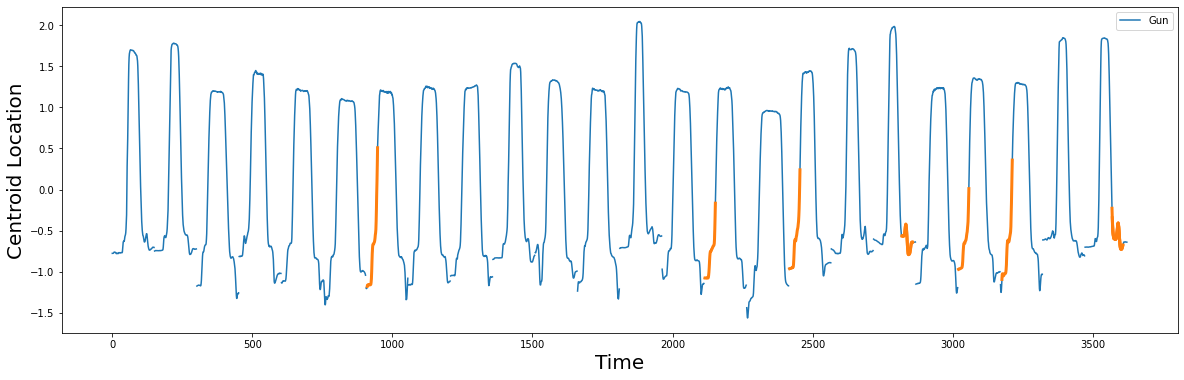

In [21]:
gun_shapelets = []
for i in idx:
    shapelet = gun_df.iloc[i : i + m, 0]
    gun_shapelets.append(shapelet)
plt.xlabel("Time", fontsize="20")
plt.ylabel('Centroid Location', fontsize='20')
plt.plot(gun_df, label="Gun")
for i, shapelet in zip(idx, gun_shapelets):
    plt.plot(range(i, i + m), shapelet, color="C1", linewidth=3.0)
plt.legend()
plt.show()

In [22]:
clf = tree.DecisionTreeClassifier()
for i, (gun_shapelet, point_shapelet) in enumerate(zip(gun_shapelets, point_shapelets)):
    X_train_gun = distance_to_shapelet(train_df.iloc[:, 1:], gun_shapelet)
    X_train_point = distance_to_shapelet(train_df.iloc[:, 1:], point_shapelet)
    X_train = np.concatenate((X_train_gun, X_train_point), axis=1)
    X_test_gun = distance_to_shapelet(test_df.iloc[:, 1:], gun_shapelet)
    X_test_point = distance_to_shapelet(test_df.iloc[:, 1:], point_shapelet)
    X_test = np.concatenate((X_test_gun, X_test_point), axis=1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Accuracy for shapelet {i} = {round(metrics.accuracy_score(y_test, y_pred), 3)}")

Accuracy for shapelet 0 = 0.913
Accuracy for shapelet 1 = 0.853
Accuracy for shapelet 2 = 0.813
Accuracy for shapelet 3 = 0.953
Accuracy for shapelet 4 = 0.933
Accuracy for shapelet 5 = 0.867
Accuracy for shapelet 6 = 0.887
Accuracy for shapelet 7 = 0.867
Accuracy for shapelet 8 = 0.867
Accuracy for shapelet 9 = 0.913


https://github.com/TDAmeritrade/stumpy/tree/main/notebooks
TUTORIAL FOR DIFFERENT MODULES OF STUMPY

https://github.com/sktime/sktime-shapelets-forest SHAPELETS FOREST FOR MTS CLASSIFICATION